<a href="https://colab.research.google.com/github/batul02/Power_Demand_Prediction/blob/master/Power_Demand_CSM_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Power Demand Forecasting with Integrated Weather Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
# from statsmodels.tsa.arima.model import ARIMA
import requests
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Data Preparation:

In [3]:
# Loading datasets
power_data = pd.read_csv("/content/time_series_60min_singleindex_filtered(in).csv", parse_dates=['utc_timestamp'])
weather_data = pd.read_csv("weather_data.csv", parse_dates=['utc_timestamp'])

# Merging datasets on time (utc_timestamp)
data = pd.merge(power_data, weather_data, on='utc_timestamp')
data.set_index('utc_timestamp', inplace=True)

# Filtering the date range
data = data['2015-01-01':'2019-12-31']

# Handle missing values by forward filling
data.fillna(method='ffill', inplace=True)
print(data.head())

# List all available columns to debug issues
print("Available columns in the dataset:")
print(data.columns)

                                 cet_cest_timestamp  \
utc_timestamp                                         
2015-01-01 00:00:00+00:00  2015-01-01T01:00:00+0100   
2015-01-01 01:00:00+00:00  2015-01-01T02:00:00+0100   
2015-01-01 02:00:00+00:00  2015-01-01T03:00:00+0100   
2015-01-01 03:00:00+00:00  2015-01-01T04:00:00+0100   
2015-01-01 04:00:00+00:00  2015-01-01T05:00:00+0100   

                           DE_load_actual_entsoe_transparency  \
utc_timestamp                                                   
2015-01-01 00:00:00+00:00                               41151   
2015-01-01 01:00:00+00:00                               40135   
2015-01-01 02:00:00+00:00                               39106   
2015-01-01 03:00:00+00:00                               38765   
2015-01-01 04:00:00+00:00                               38941   

                           DE_load_forecast_entsoe_transparency  \
utc_timestamp                                                     
2015-01-01 00:00:00+00:0

<ipython-input-3-5ecd5eb92d15>:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [4]:
# Defining countries of interest
countries = ['FR', 'DE', 'ES', 'IT', 'NL', 'PL']

# Correcting the column selection
# Ensuring columns actually exist in data
temperature_columns = [col for col in data.columns if "_temperature" in col]
radiation_columns = [col for col in data.columns if "_radiation_direct_horizontal" in col]

print("Selected temperature columns:", temperature_columns)
print("Selected radiation columns:", radiation_columns)

Selected temperature columns: ['AT_temperature', 'BE_temperature', 'BG_temperature', 'CH_temperature', 'CZ_temperature', 'DE_temperature', 'DK_temperature', 'EE_temperature', 'ES_temperature', 'FI_temperature', 'FR_temperature', 'GB_temperature', 'GR_temperature', 'HR_temperature', 'HU_temperature', 'IE_temperature', 'IT_temperature', 'LT_temperature', 'LU_temperature', 'LV_temperature', 'NL_temperature', 'NO_temperature', 'PL_temperature', 'PT_temperature', 'RO_temperature', 'SE_temperature', 'SI_temperature', 'SK_temperature']
Selected radiation columns: ['AT_radiation_direct_horizontal', 'BE_radiation_direct_horizontal', 'BG_radiation_direct_horizontal', 'CH_radiation_direct_horizontal', 'CZ_radiation_direct_horizontal', 'DE_radiation_direct_horizontal', 'DK_radiation_direct_horizontal', 'EE_radiation_direct_horizontal', 'ES_radiation_direct_horizontal', 'FI_radiation_direct_horizontal', 'FR_radiation_direct_horizontal', 'GB_radiation_direct_horizontal', 'GR_radiation_direct_horizon

In [5]:
# Combining temperature and radiation columns
selected_columns = temperature_columns + radiation_columns
weather_data_filtered = data[selected_columns]

# Ensuring the filtered data is not empty
if weather_data_filtered.empty:
    print("Filtered weather data is empty. Check column names or data content.")
else:
    print("Filtered weather data shape:", weather_data_filtered.shape)

Filtered weather data shape: (43823, 56)


In [6]:
# Normalizing the weather data
scaler = StandardScaler()
weather_data_filtered = pd.DataFrame(
    scaler.fit_transform(weather_data_filtered),
    columns=weather_data_filtered.columns,
    index=weather_data_filtered.index
)

# Updating the main dataframe with normalized weather data
data.update(weather_data_filtered)

# Aggregating the data to daily frequency and calculating the mean of numerical columns
numeric_columns = data.select_dtypes(include=np.number).columns
daily_data = data[numeric_columns].resample('D').mean()

In [7]:
# Split into training and testing datasets
train = daily_data['2015-01-01':'2018-12-31']
test = daily_data['2019-01-01':'2019-12-31']

# Printing the final train and test data for verification
print("Training Data:")
print(train.shape)
print("\nTesting Data:")
print(test.shape)

Training Data:
(1461, 120)

Testing Data:
(365, 120)


### Exploratory Data Analysis (EDA):

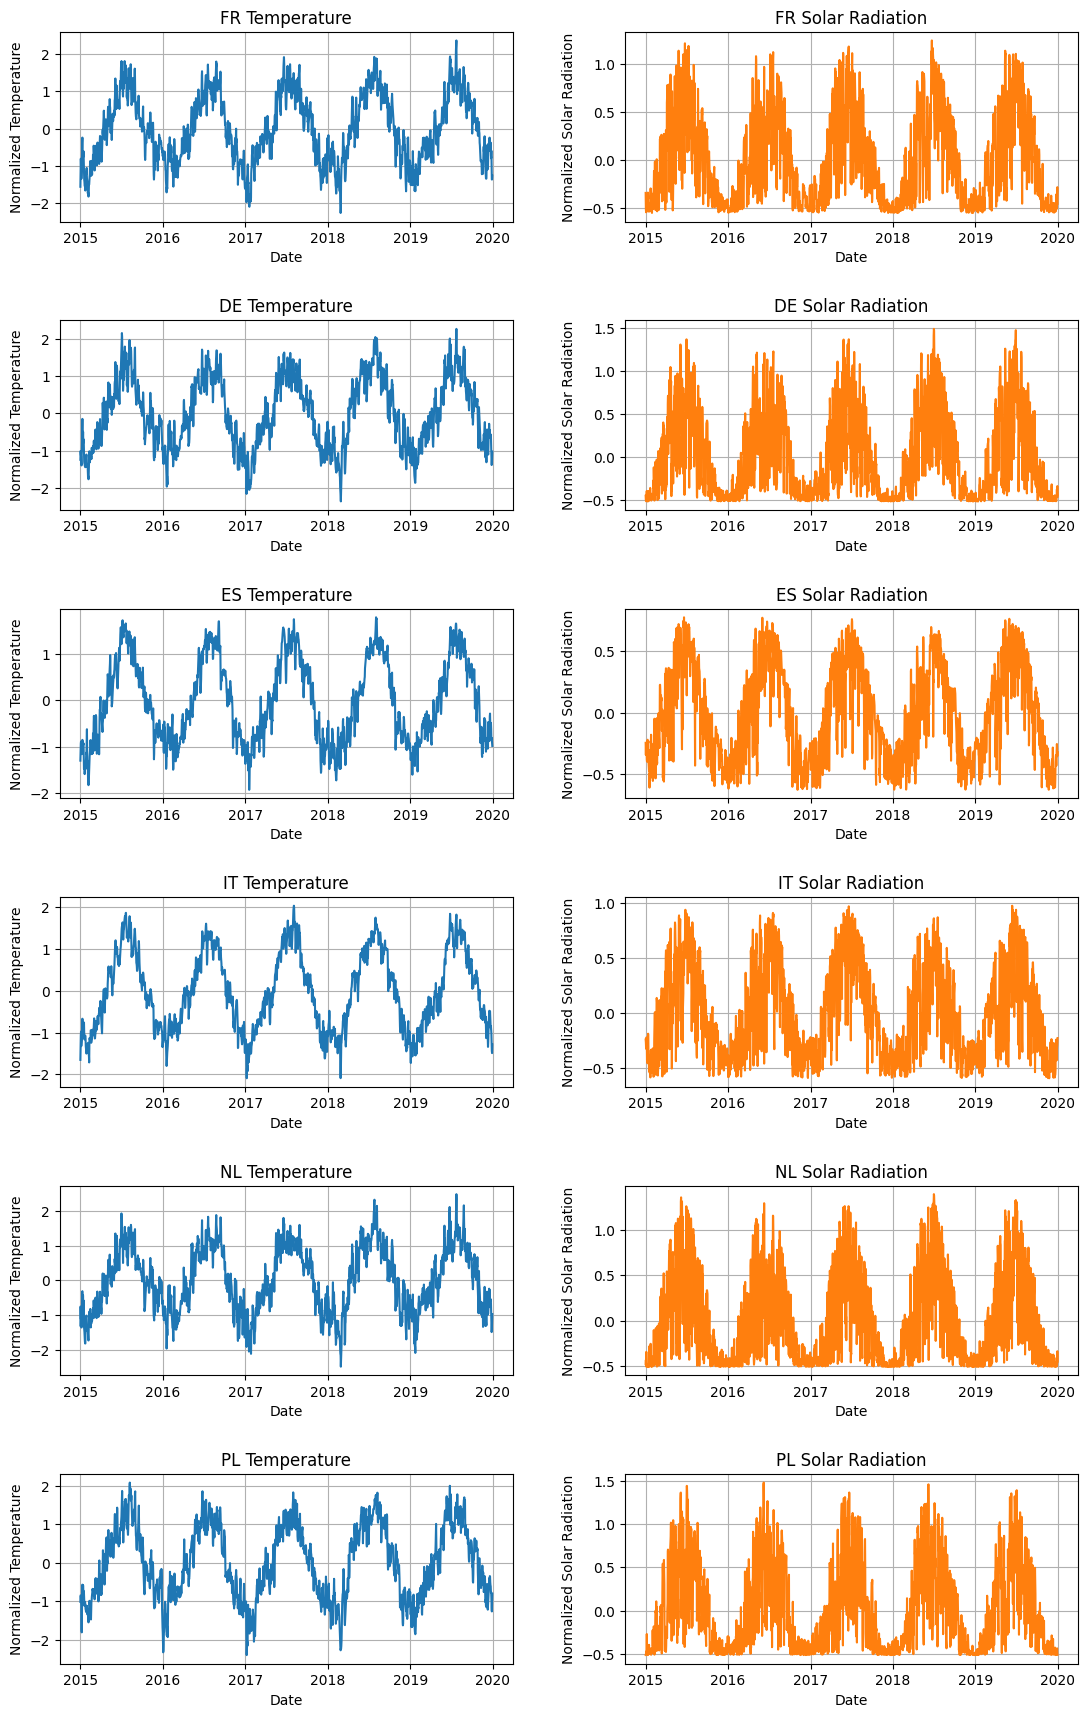

In [8]:
# Plotting demand and weather variables (temperature and solar radiation for all countries)
# We'll plot for each country’s temperature and solar radiation

fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(12, 18))  # 6 rows (one per country) and 2 columns (temperature, radiation)
fig.tight_layout(pad=5.0)

# Country list
countries = ['FR', 'DE', 'ES', 'IT', 'NL', 'PL']

# Looping through countries and plotting
for i, country in enumerate(countries):
    ax_temp = axes[i, 0]  # Temperature column
    ax_radiation = axes[i, 1]  # Radiation column

    # Plotting temperature for the country
    ax_temp.plot(daily_data.index, daily_data[f'{country}_temperature'], label=f'{country} Temperature', color='tab:blue')
    ax_temp.set_title(f'{country} Temperature')
    ax_temp.set_xlabel('Date')
    ax_temp.set_ylabel('Normalized Temperature')
    ax_temp.grid(True)

    # Plotting solar radiation for the country
    ax_radiation.plot(daily_data.index, daily_data[f'{country}_radiation_direct_horizontal'],
                      label=f'{country} Solar Radiation', color='tab:orange')
    ax_radiation.set_title(f'{country} Solar Radiation')
    ax_radiation.set_xlabel('Date')
    ax_radiation.set_ylabel('Normalized Solar Radiation')
    ax_radiation.grid(True)

plt.show()

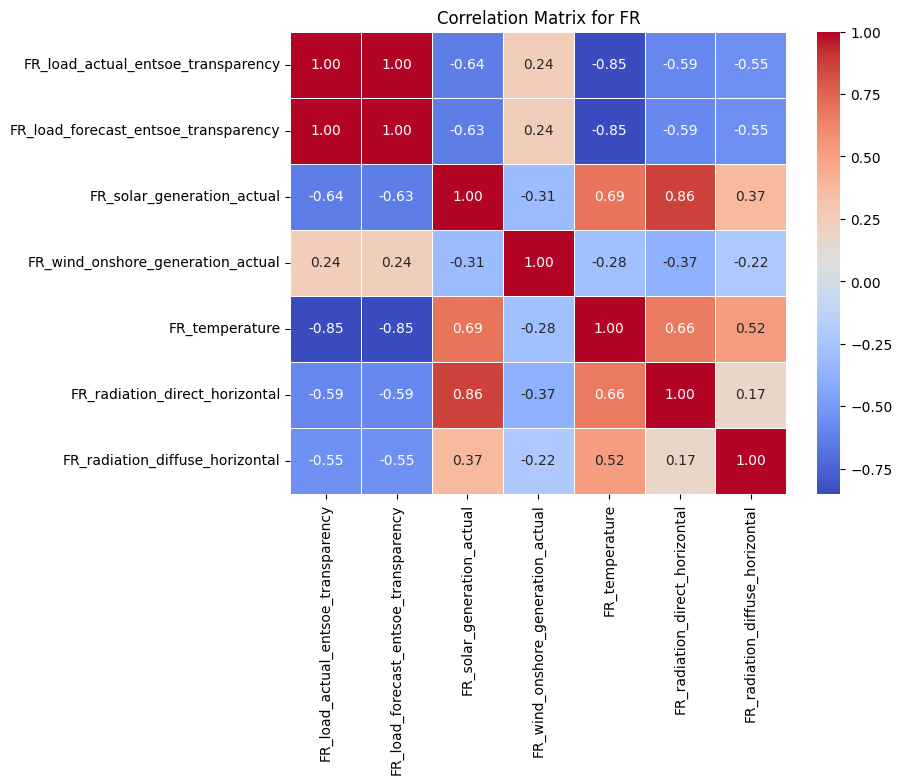

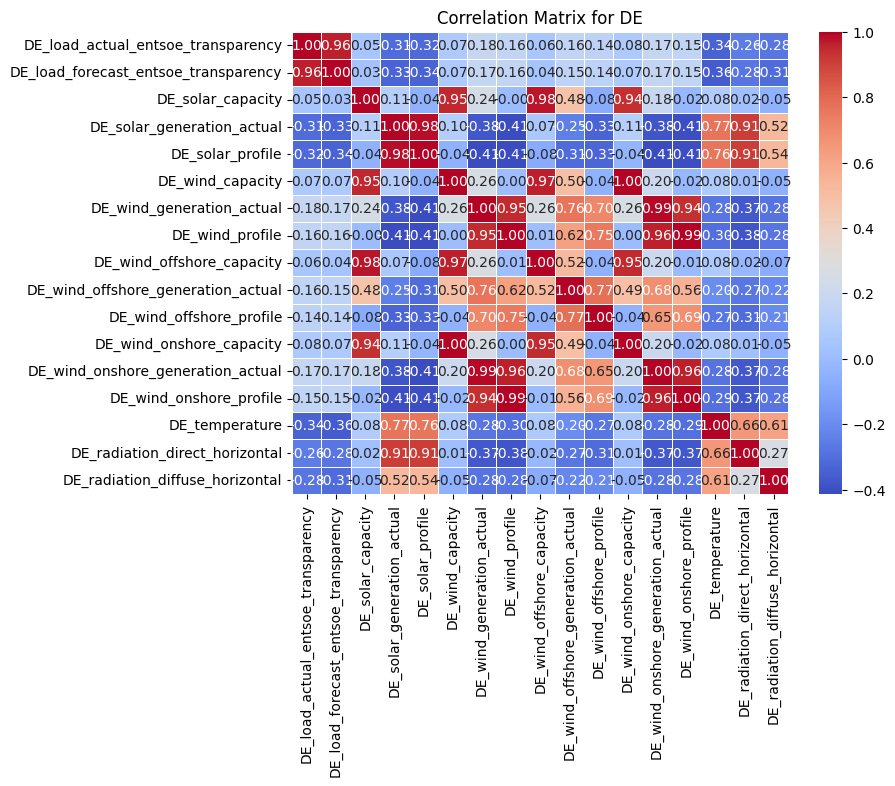

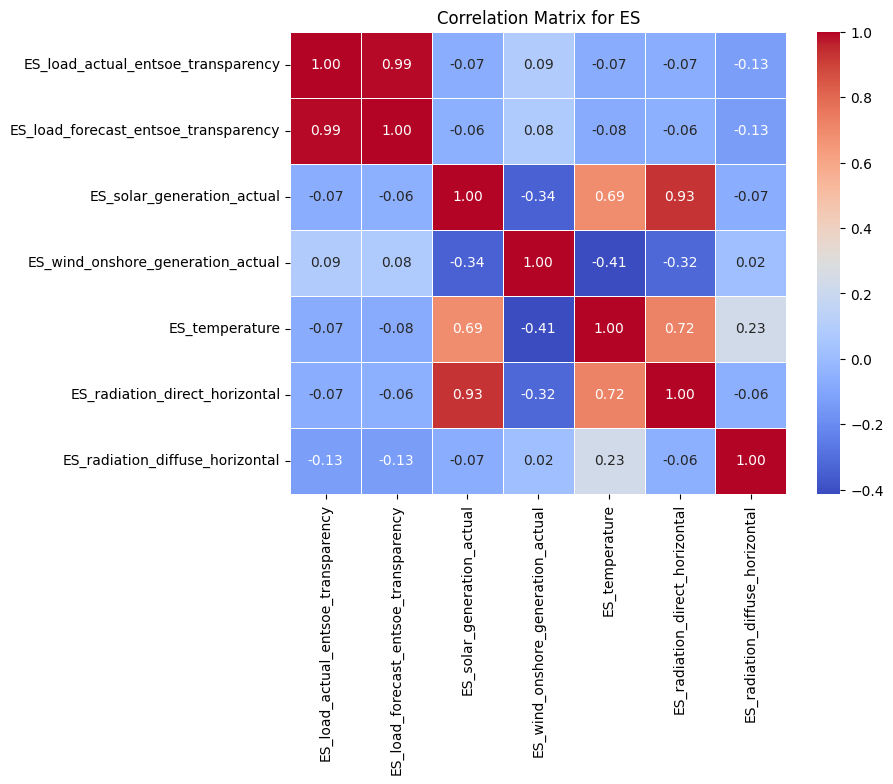

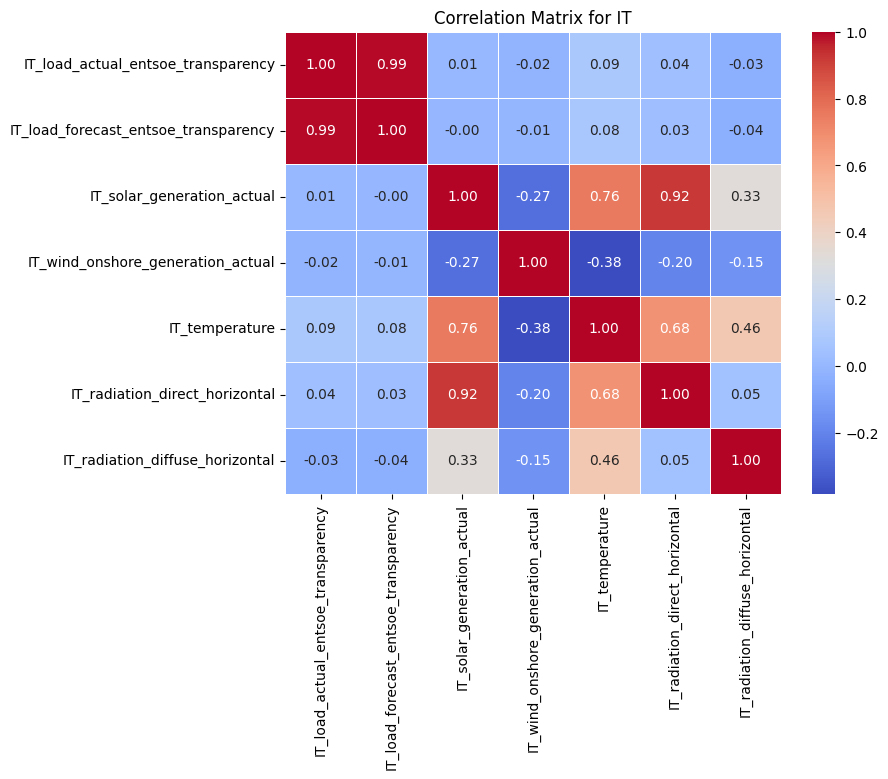

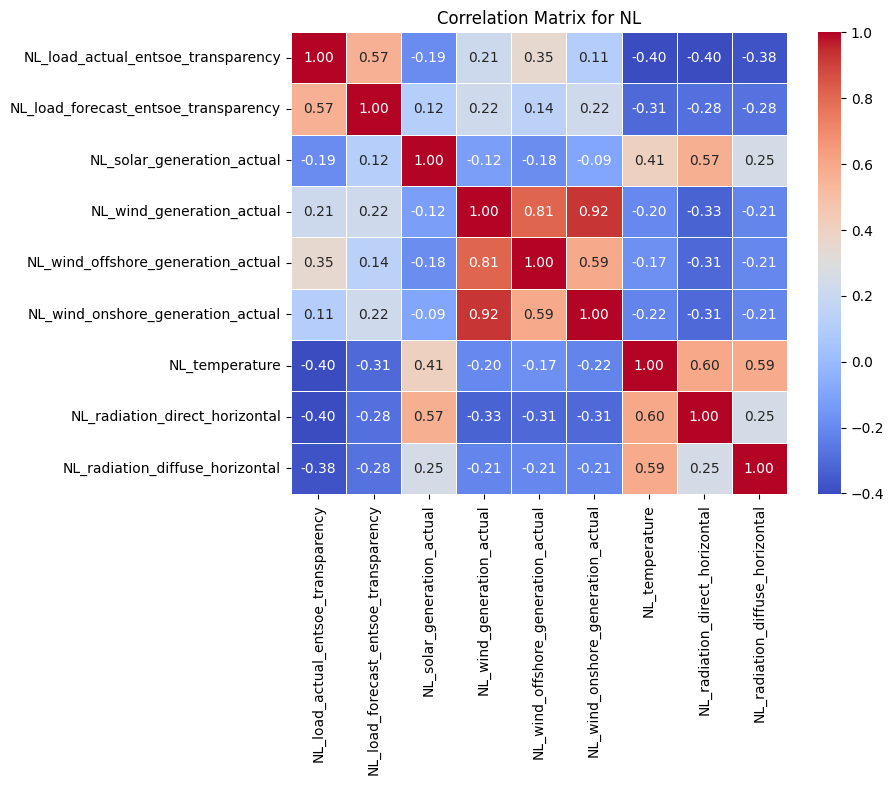

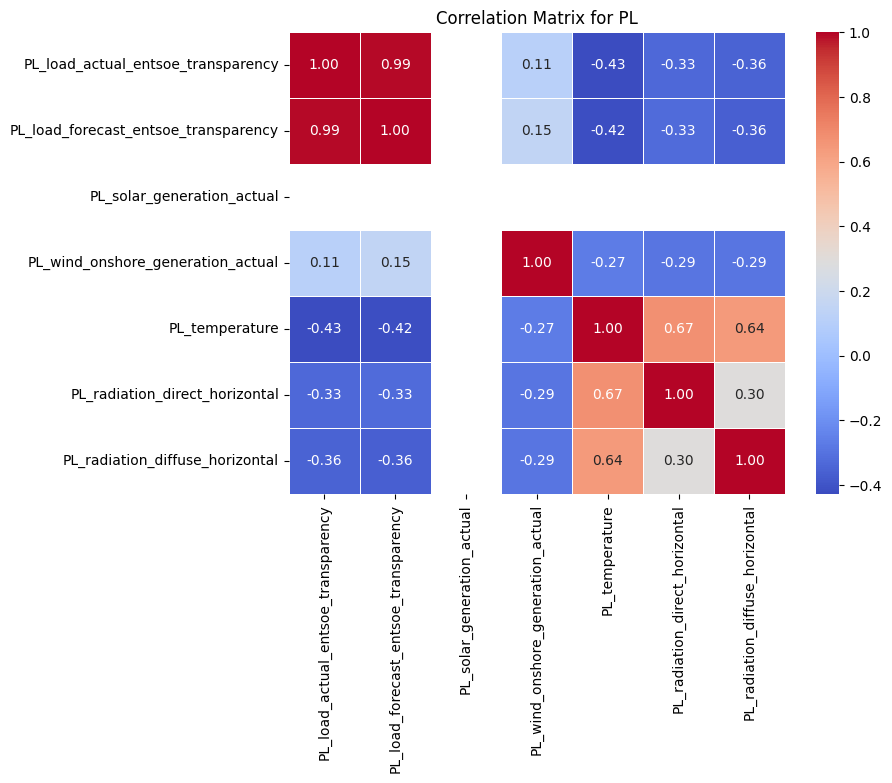

In [9]:
# Looping through each country and generating a correlation heatmap
for country in countries:
    # Filtering columns related to the current country
    country_columns = [col for col in daily_data.columns if col.startswith(country)]

    # Computing the correlation matrix for the current country
    country_corr = daily_data[country_columns].corr()

    # Plotting the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(country_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title(f"Correlation Matrix for {country}")
    plt.show()

### Feature Engineering:

In [10]:
# Creating lag features for each country
for country in countries:
    # (lag 1 to 7)
    for lag in range(1, 8):
        daily_data[f'{country}_demand_lag_{lag}'] = daily_data[f'{country}_load_actual_entsoe_transparency'].shift(lag)

# Adding rolling averages for demand (7-day rolling mean for each country)
for country in countries:
    daily_data[f'{country}_rolling_mean_7'] = daily_data[f'{country}_load_actual_entsoe_transparency'].rolling(window=7).mean()

# Adding holiday/weekend features
daily_data['day_of_week'] = daily_data.index.dayofweek
daily_data['is_weekend'] = daily_data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Adding lag features for weather data (temperature and solar radiation)
for country in countries:
    for lag in range(1, 8):
        daily_data[f'{country}_temperature_lag_{lag}'] = daily_data[f'{country}_temperature'].shift(lag)
        daily_data[f'{country}_solar_radiation_lag_{lag}'] = daily_data[f'{country}_radiation_direct_horizontal'].shift(lag)

# Adding rolling averages for weather variables (7-day rolling mean for temperature and solar radiation)
for country in countries:
    daily_data[f'{country}_temperature_rolling_mean_7'] = daily_data[f'{country}_temperature'].rolling(window=7).mean()
    daily_data[f'{country}_solar_radiation_rolling_mean_7'] = daily_data[f'{country}_radiation_direct_horizontal'].rolling(window=7).mean()

# Verifing the result by printing a sample of the data
print(daily_data.columns)

Index(['DE_load_actual_entsoe_transparency',
       'DE_load_forecast_entsoe_transparency', 'DE_solar_capacity',
       'DE_solar_generation_actual', 'DE_solar_profile', 'DE_wind_capacity',
       'DE_wind_generation_actual', 'DE_wind_profile',
       'DE_wind_offshore_capacity', 'DE_wind_offshore_generation_actual',
       ...
       'DE_temperature_rolling_mean_7', 'DE_solar_radiation_rolling_mean_7',
       'ES_temperature_rolling_mean_7', 'ES_solar_radiation_rolling_mean_7',
       'IT_temperature_rolling_mean_7', 'IT_solar_radiation_rolling_mean_7',
       'NL_temperature_rolling_mean_7', 'NL_solar_radiation_rolling_mean_7',
       'PL_temperature_rolling_mean_7', 'PL_solar_radiation_rolling_mean_7'],
      dtype='object', length=266)


<ipython-input-10-ed300b3edc80>:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  daily_data[f'{country}_temperature_lag_{lag}'] = daily_data[f'{country}_temperature'].shift(lag)
<ipython-input-10-ed300b3edc80>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  daily_data[f'{country}_solar_radiation_lag_{lag}'] = daily_data[f'{country}_radiation_direct_horizontal'].shift(lag)
<ipython-input-10-ed300b3edc80>:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh

In [11]:
# nan_count = daily_data['PL_solar_radiation_rolling_mean_7'].isna().sum()
# print(f"Number of NaN values in PL_solar_radiation_rolling_mean_7: {nan_count}")

Number of NaN values in PL_solar_radiation_rolling_mean_7: 6


## Classical Models - VARMAX(with weather data as exogenous variables)

In [12]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX

# Combining data for all countries into one DataFrame
endog = train[[f'{country}_load_actual_entsoe_transparency' for country in countries]]
exog = train[[f'{country}_temperature' for country in countries] +
             [f'{country}_radiation_direct_horizontal' for country in countries]]

# Combining test data for forecasting
test_endog = test[[f'{country}_load_actual_entsoe_transparency' for country in countries]]
test_exog = test[[f'{country}_temperature' for country in countries] +
                 [f'{country}_radiation_direct_horizontal' for country in countries]]

# # Initializing and fitting the SARIMAX model
# model = SARIMAX(endog, exog=exog, order=(1, 1, 1), time_varying_regression=False)
# results = model.fit()

# Initializing and fitting the VARMAX model
model_varmax = VARMAX(endog, exog=exog, order=(1, 1))
results = model_varmax.fit()

# Forecast
forecast = results.forecast(steps=len(test), exog=test_exog)

# Forecast for all countries
# forecast = results.get_forecast(steps=len(test_endog), exog=test_exog)
forecast_mean = forecast

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models

In [13]:
# Calculating error metrics for each country
error_metrics = {}
for i, country in enumerate(countries):
    actual = test_endog.iloc[:, i]
    predicted = forecast_mean.iloc[:, i]
    rmse = root_mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    mape = mean_absolute_percentage_error(actual, predicted)
    error_metrics[country] = {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

# Printing the error metrics
print("\nError Metrics for ARIMA:")
for country, metrics in error_metrics.items():
    print(f"{country} - RMSE: {metrics['RMSE']:.2f}, MAE: {metrics['MAE']:.2f}, MAPE: {metrics['MAPE']:.2%}")


Error Metrics for ARIMA:
FR - RMSE: 5388.15, MAE: 4317.86, MAPE: 8.34%
DE - RMSE: 6138.56, MAE: 5533.17, MAPE: 10.34%
ES - RMSE: 2694.98, MAE: 2133.54, MAPE: 7.72%
IT - RMSE: 4876.16, MAE: 4104.18, MAPE: 12.82%
NL - RMSE: 1081.08, MAE: 963.67, MAPE: 7.36%
PL - RMSE: 1967.74, MAE: 1748.85, MAPE: 9.38%


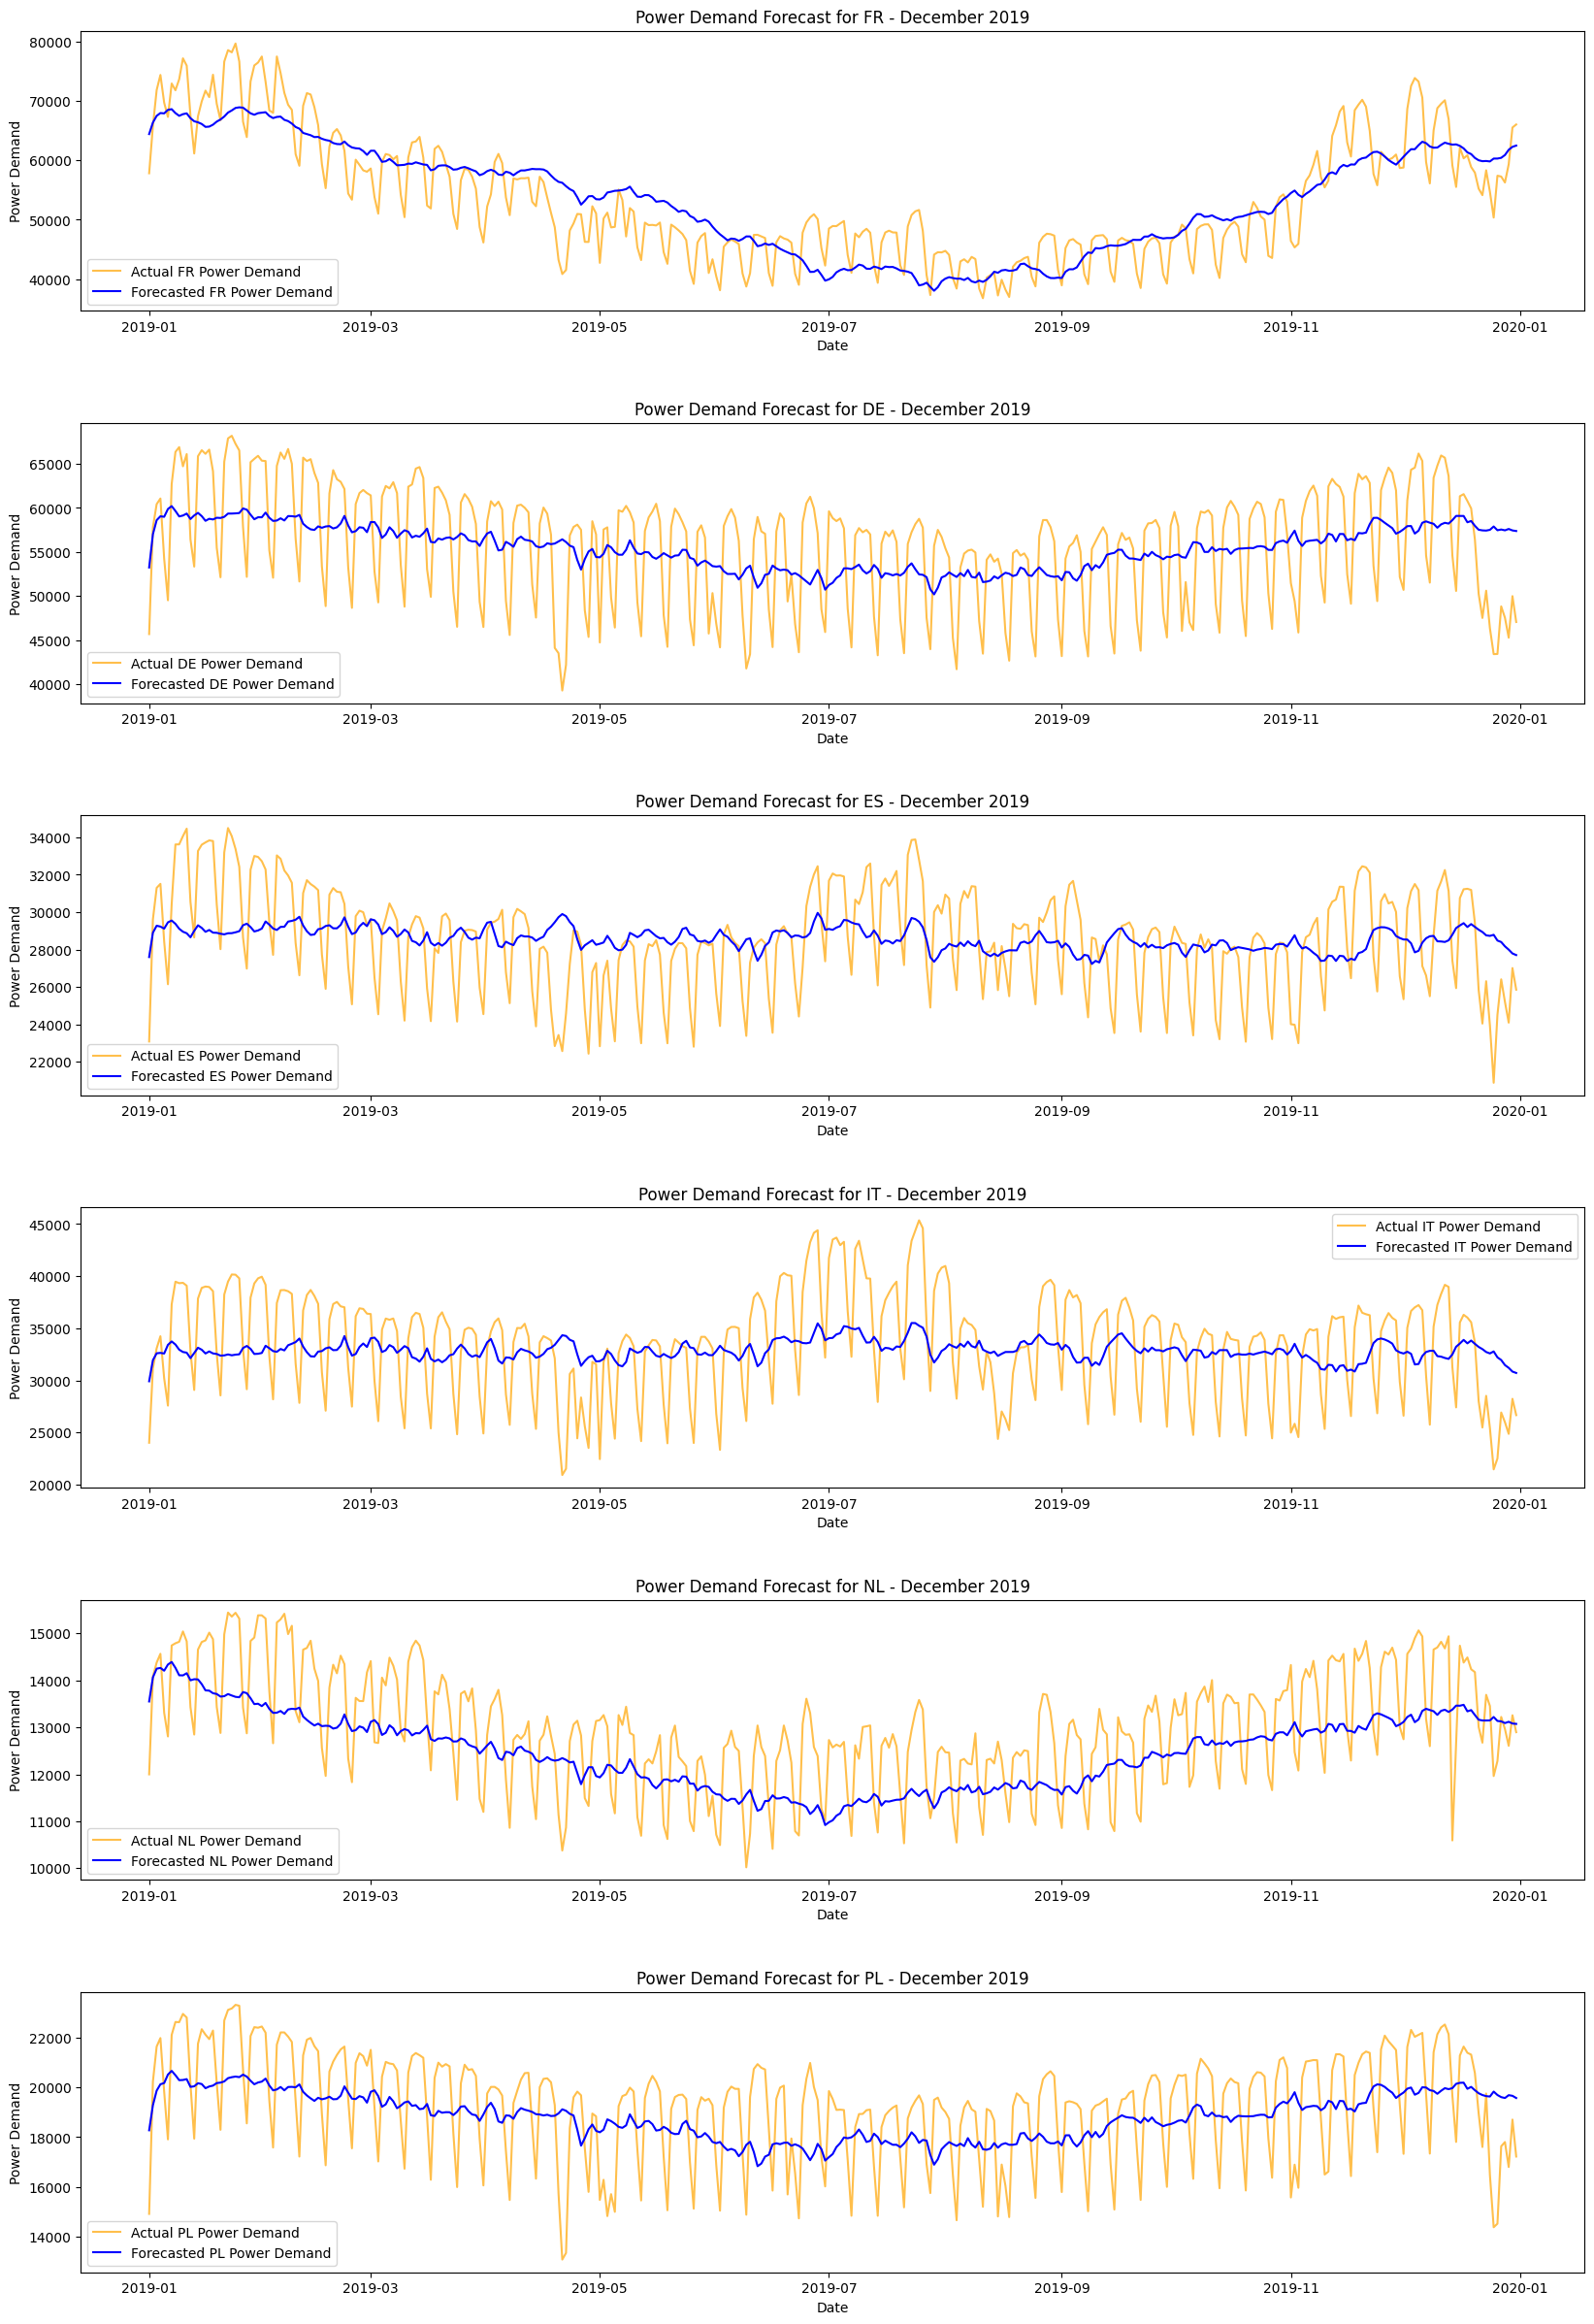

In [14]:
# Visualizing the forecast for each country (plotting actual vs predicted)
plt.figure(figsize=(20, 30))

for i, country in enumerate(countries):
    plt.subplot(len(countries), 1, i + 1)
    # Plotting the actual power demand
    plt.plot(test_endog.index, test_endog.iloc[:, i], label=f'Actual {country} Power Demand', color='orange', alpha=0.7)

    # Plotting the forecasted power demand
    plt.plot(forecast.index, forecast_mean.iloc[:, i], label=f'Forecasted {country} Power Demand', color='blue')
    plt.title(f'Power Demand Forecast for {country} - December 2019')
    plt.xlabel('Date')
    plt.ylabel('Power Demand')
    plt.legend()

# plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

## Machine Learning Models - XGBoost VS RF

In [15]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

# Defining countries and target columns
target_columns = [f'{country}_load_actual_entsoe_transparency' for country in countries]

# Features and targets for all countries combined
X_train = train.drop(columns=target_columns)
y_train = train[target_columns]

X_test = test.drop(columns=target_columns)
y_test = test[target_columns]

# Training a Random Forest model for all countries
rf_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100))
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Training an XGBoost model for all countries
xgb_model = MultiOutputRegressor(XGBRegressor(n_estimators=100, learning_rate=0.1))
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

In [16]:
# Initializing dictionaries to store metrics for each model
rf_metrics = {}
xgb_metrics = {}

# Looping through each country to calculate metrics
for i, country in enumerate(countries):
    # Extract actual and predicted values for the current country
    actual = y_test.iloc[:, i]
    rf_pred = rf_predictions[:, i]
    xgb_pred = xgb_predictions[:, i]

    # Calculating metrics for Random Forest
    rf_rmse = root_mean_squared_error(actual, rf_pred)
    rf_mae = mean_absolute_error(actual, rf_pred)
    rf_mape = mean_absolute_percentage_error(actual, rf_pred)
    rf_metrics[country] = {'RMSE': rf_rmse, 'MAE': rf_mae, 'MAPE': rf_mape}

    # Calculating metrics for XGBoost
    xgb_rmse = root_mean_squared_error(actual, xgb_pred)
    xgb_mae = mean_absolute_error(actual, xgb_pred)
    xgb_mape = mean_absolute_percentage_error(actual, xgb_pred)
    xgb_metrics[country] = {'RMSE': xgb_rmse, 'MAE': xgb_mae, 'MAPE': xgb_mape}

# Printing metrics for Random Forest and XGBoost
print("Error Metrics for Random Forest:")
for country, metrics in rf_metrics.items():
    print(f"{country} - RMSE: {metrics['RMSE']:.2f}, MAE: {metrics['MAE']:.2f}, MAPE: {metrics['MAPE']:.2%}")

print("\nError Metrics for XGBoost:")
for country, metrics in xgb_metrics.items():
    print(f"{country} - RMSE: {metrics['RMSE']:.2f}, MAE: {metrics['MAE']:.2f}, MAPE: {metrics['MAPE']:.2%}")

Error Metrics for Random Forest:
FR - RMSE: 696.21, MAE: 533.55, MAPE: 1.00%
DE - RMSE: 1542.46, MAE: 1167.06, MAPE: 2.14%
ES - RMSE: 295.43, MAE: 227.20, MAPE: 0.80%
IT - RMSE: 662.17, MAE: 517.35, MAPE: 1.61%
NL - RMSE: 438.50, MAE: 312.97, MAPE: 2.44%
PL - RMSE: 285.83, MAE: 223.50, MAPE: 1.19%

Error Metrics for XGBoost:
FR - RMSE: 678.45, MAE: 506.03, MAPE: 0.95%
DE - RMSE: 1564.06, MAE: 1173.57, MAPE: 2.16%
ES - RMSE: 287.64, MAE: 221.75, MAPE: 0.79%
IT - RMSE: 654.30, MAE: 510.89, MAPE: 1.58%
NL - RMSE: 440.21, MAE: 308.78, MAPE: 2.42%
PL - RMSE: 290.62, MAE: 221.47, MAPE: 1.18%


In [17]:
# Checking shapes of the data --> ensuring that we are working with the correct lengths (365 days for each country)
print("y_test shape:", y_test.shape)
print("rf_predictions shape:", rf_predictions.shape)
print("xgb_predictions shape:", xgb_predictions.shape)

y_test shape: (365, 6)
rf_predictions shape: (365, 6)
xgb_predictions shape: (365, 6)


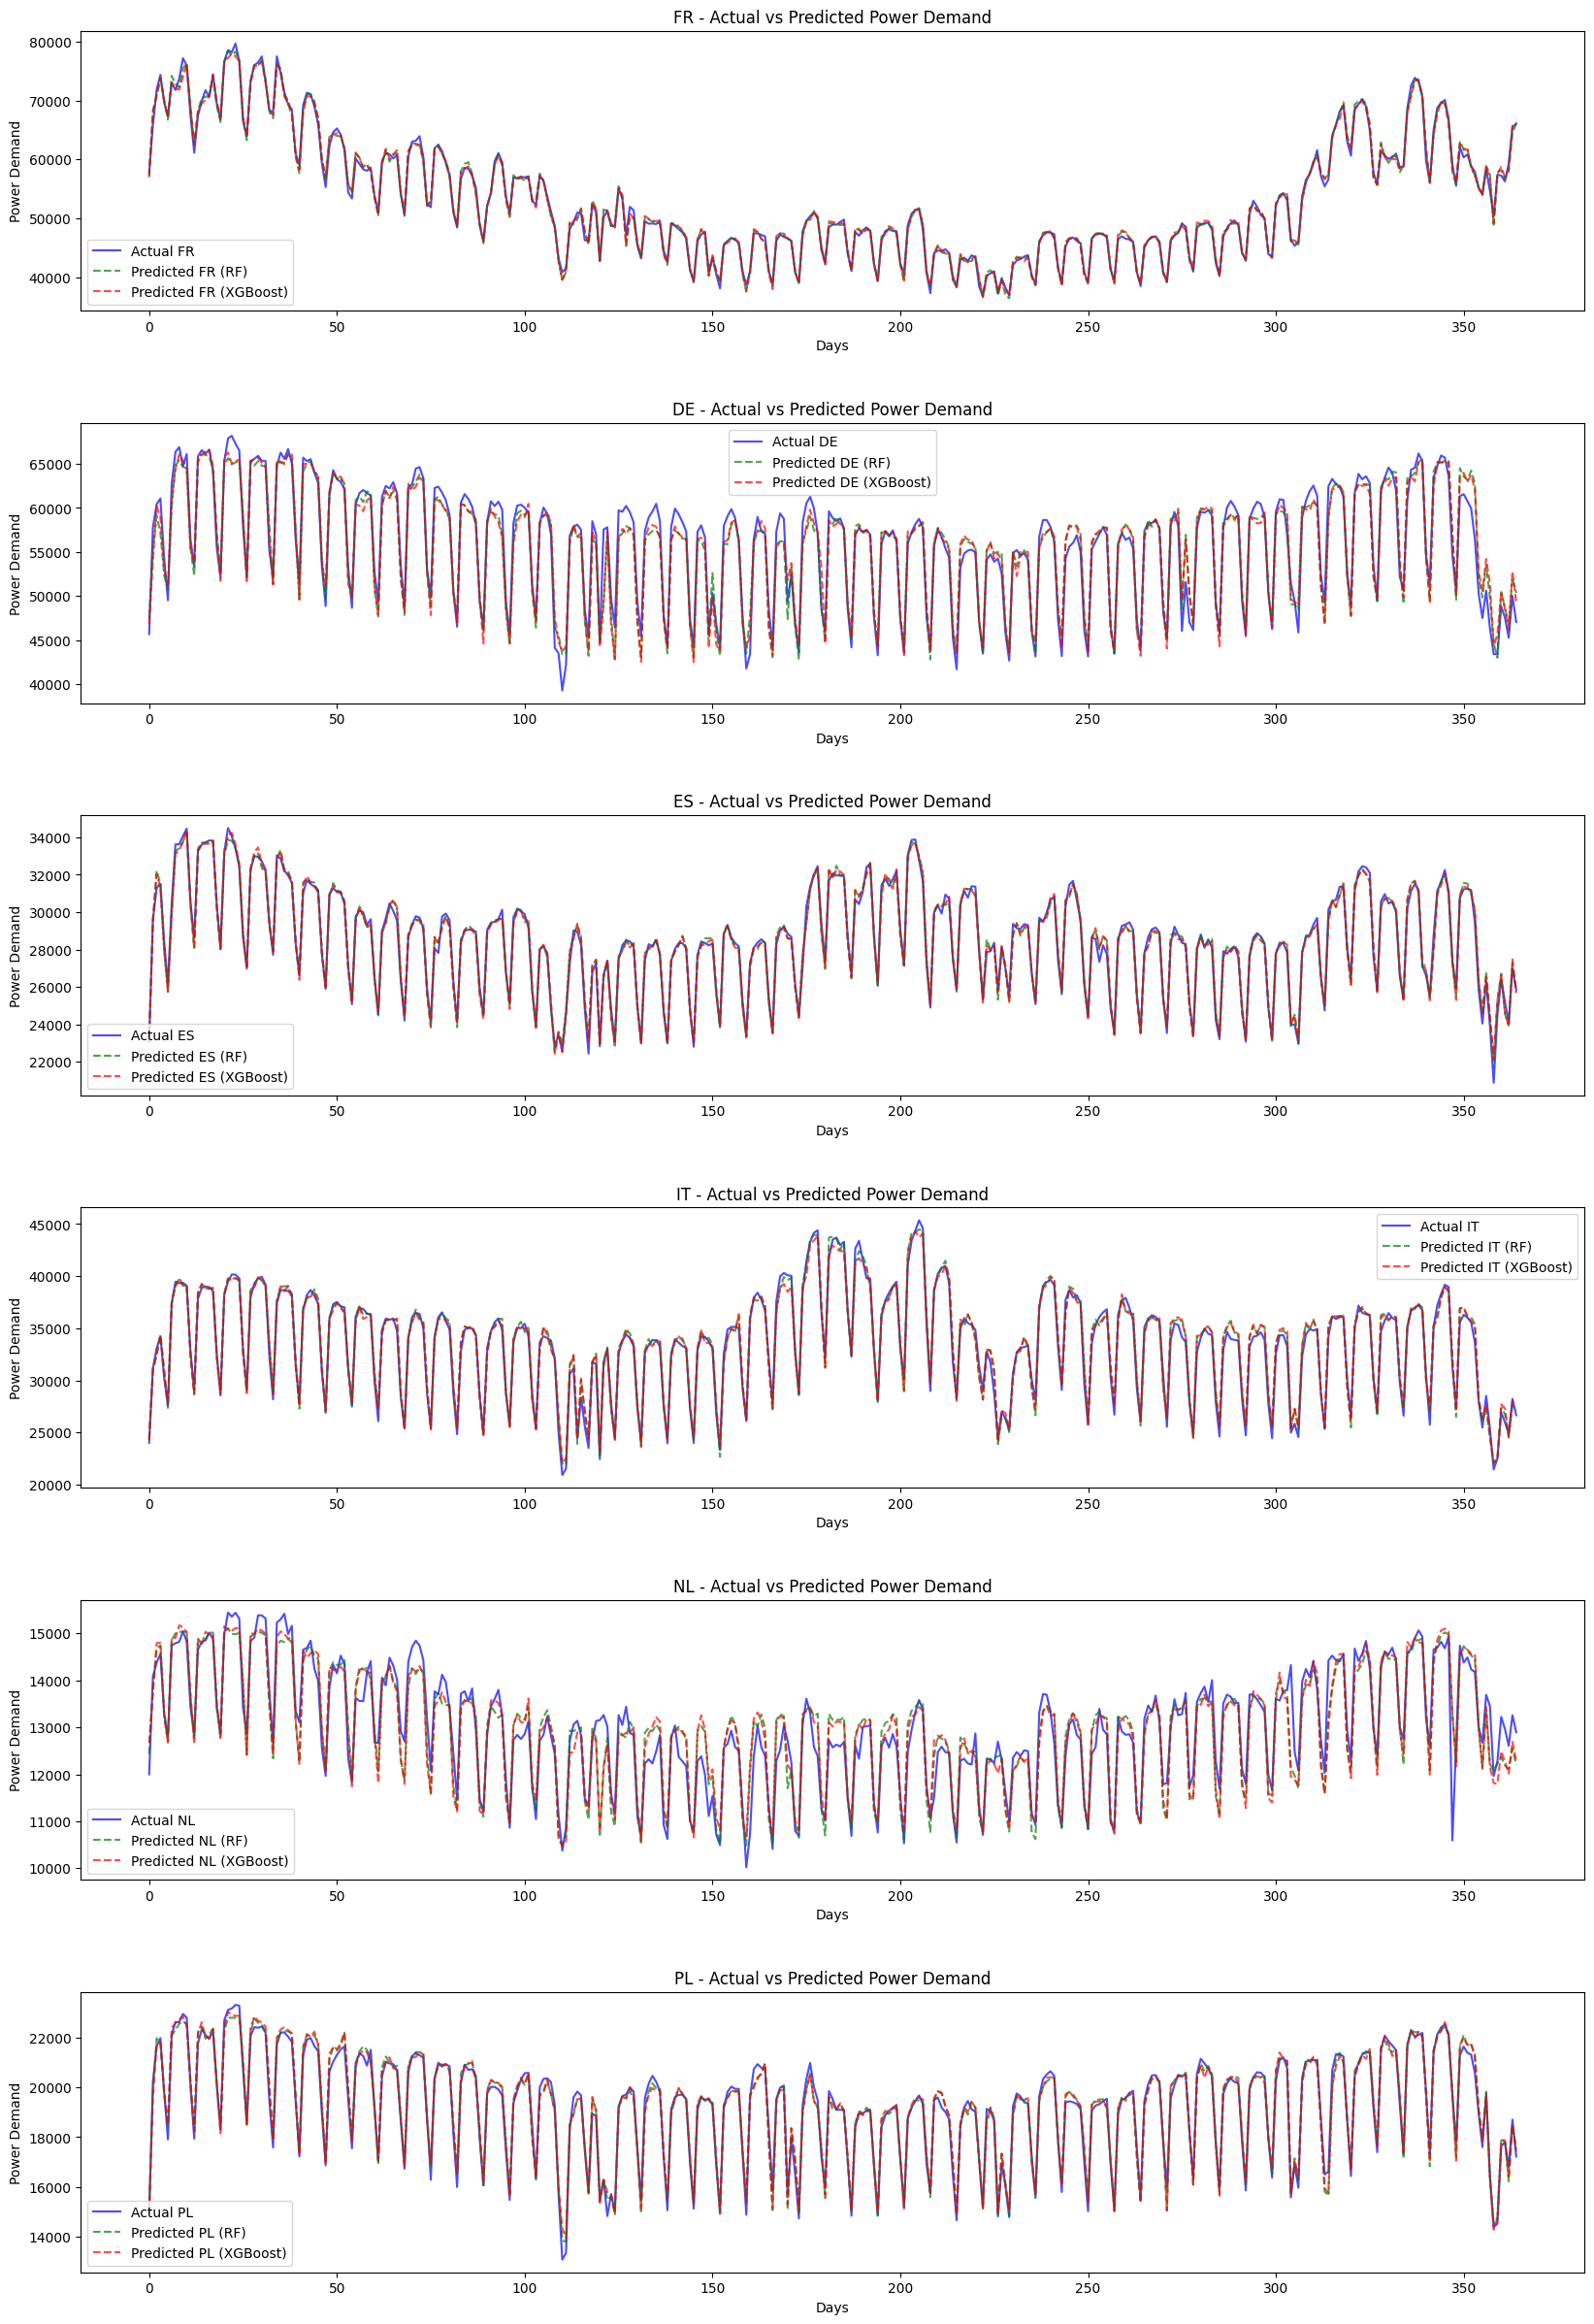

In [18]:
# Setting up the figure size for better visualization
plt.figure(figsize=(20, 30))

# Looping through each country to create a plot
for i, country in enumerate(countries):
    plt.subplot(len(countries), 1, i + 1) #subplot

    actual_values = y_test.iloc[:, i]
    rf_pred_values = rf_predictions[:, i]
    xgb_pred_values = xgb_predictions[:, i]

    # Creating x-axis for plotting (range of 365 days)
    x_axis = np.arange(365)

    # Plotting actual vs predicted values for each model (Random Forest and XGBoost)
    plt.plot(x_axis, actual_values, label=f'Actual {country}', color='blue', alpha=0.7)
    plt.plot(x_axis, rf_pred_values, label=f'Predicted {country} (RF)', color='green', linestyle='--', alpha=0.7)
    plt.plot(x_axis, xgb_pred_values, label=f'Predicted {country} (XGBoost)', color='red', linestyle='--', alpha=0.7)

    plt.title(f'{country} - Actual vs Predicted Power Demand')
    plt.xlabel('Days')
    plt.ylabel('Power Demand')
    plt.legend(loc='best')

# Adjusting the layout and showing the plot
plt.subplots_adjust(hspace=0.4)
# plt.tight_layout()
plt.show()

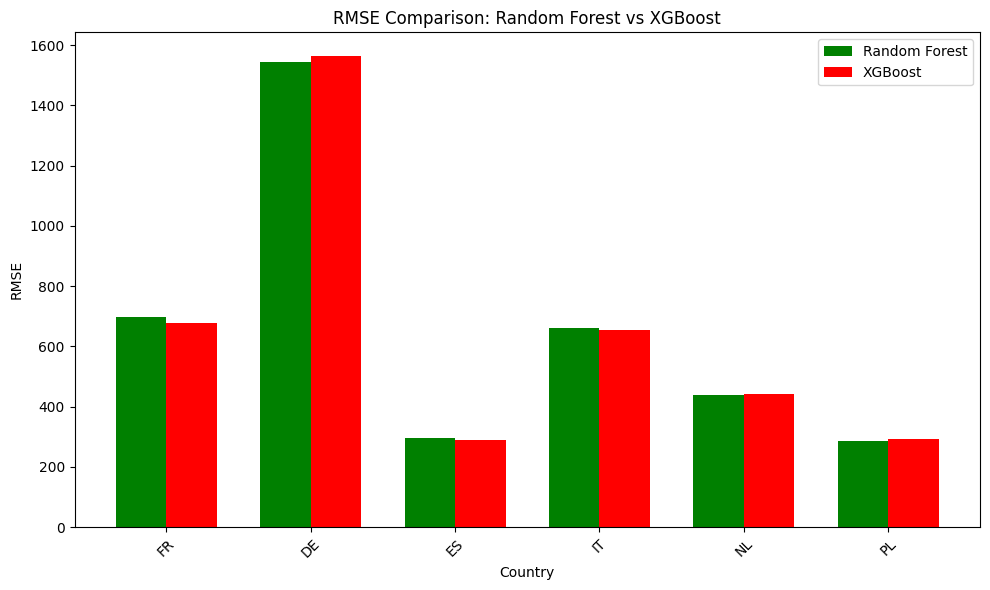

In [19]:
# Preparing data for RMSE bar plot
rf_rmse_values = [rf_metrics[country]['RMSE'] for country in countries]
xgb_rmse_values = [xgb_metrics[country]['RMSE'] for country in countries]

# Setting up the figure size for better visualization
plt.figure(figsize=(10, 6))

# Plotting the RMSE values for both Random Forest and XGBoost
width = 0.35  # Width of the bars
x = np.arange(len(countries))  # The label locations

# Creating the bars for Random Forest and XGBoost
plt.bar(x - width/2, rf_rmse_values, width, label='Random Forest', color='green')
plt.bar(x + width/2, xgb_rmse_values, width, label='XGBoost', color='red')

plt.xlabel('Country')
plt.ylabel('RMSE')
plt.title('RMSE Comparison: Random Forest vs XGBoost')
plt.xticks(x, countries, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

## Deep Learning Model - LSTM

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Target column defined above in ML model evaluation

# Normalizing the data for all countries together
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(daily_data[target_columns])

# Function to create sequences from the data (for LSTM)
def create_sequences_multivariate(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])  # Input sequence of all countries
        y.append(data[i])  # Output for all countries
    return np.array(X), np.array(y)

# Create sequences using the last 30 days of data to predict the next day
seq_length = 30
X, y = create_sequences_multivariate(scaled_data, seq_length)

# Train/test split (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
lstm_model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(len(countries))  # One output per country
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='mse')

# Train the LSTM model
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.1134
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0337
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0319
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0301
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0329
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0303
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0298
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0293
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0304
Epoch 10/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0303
Epoch 11/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0269
Epoch 12/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0279
Epoch 13/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0288
Epoch 14/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0278
Epoch 15/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0252
Epoch 16/20
4

In [21]:
# Make predictions on the test set
lstm_preds = lstm_model.predict(X_test)

# Inverse transform the predictions and actual values back to original scale
lstm_preds_original = scaler.inverse_transform(lstm_preds)
y_test_original = scaler.inverse_transform(y_test)

# Calculate RMSE for each country
lstm_metrics = {}
for i, country in enumerate(countries):
    lstm_rmse = root_mean_squared_error(y_test_original[:, i], lstm_preds_original[:, i])
    lstm_mae = mean_absolute_error(y_test_original[:, i], lstm_preds_original[:, i])
    lstm_mape = mean_absolute_percentage_error(y_test_original[:, i], lstm_preds_original[:, i])
    lstm_metrics[country] = {'RMSE': lstm_rmse, 'MAE': lstm_mae, 'MAPE': lstm_mape}

print("\nError Metrics for LSTM:")
for country, metrics in xgb_metrics.items():
    print(f"{country} - RMSE: {metrics['RMSE']:.2f}, MAE: {metrics['MAE']:.2f}, MAPE: {metrics['MAPE']:.2%}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Error Metrics for LSTM:
FR - RMSE: 678.45, MAE: 506.03, MAPE: 0.95%
DE - RMSE: 1564.06, MAE: 1173.57, MAPE: 2.16%
ES - RMSE: 287.64, MAE: 221.75, MAPE: 0.79%
IT - RMSE: 654.30, MAE: 510.89, MAPE: 1.58%
NL - RMSE: 440.21, MAE: 308.78, MAPE: 2.42%
PL - RMSE: 290.62, MAE: 221.47, MAPE: 1.18%


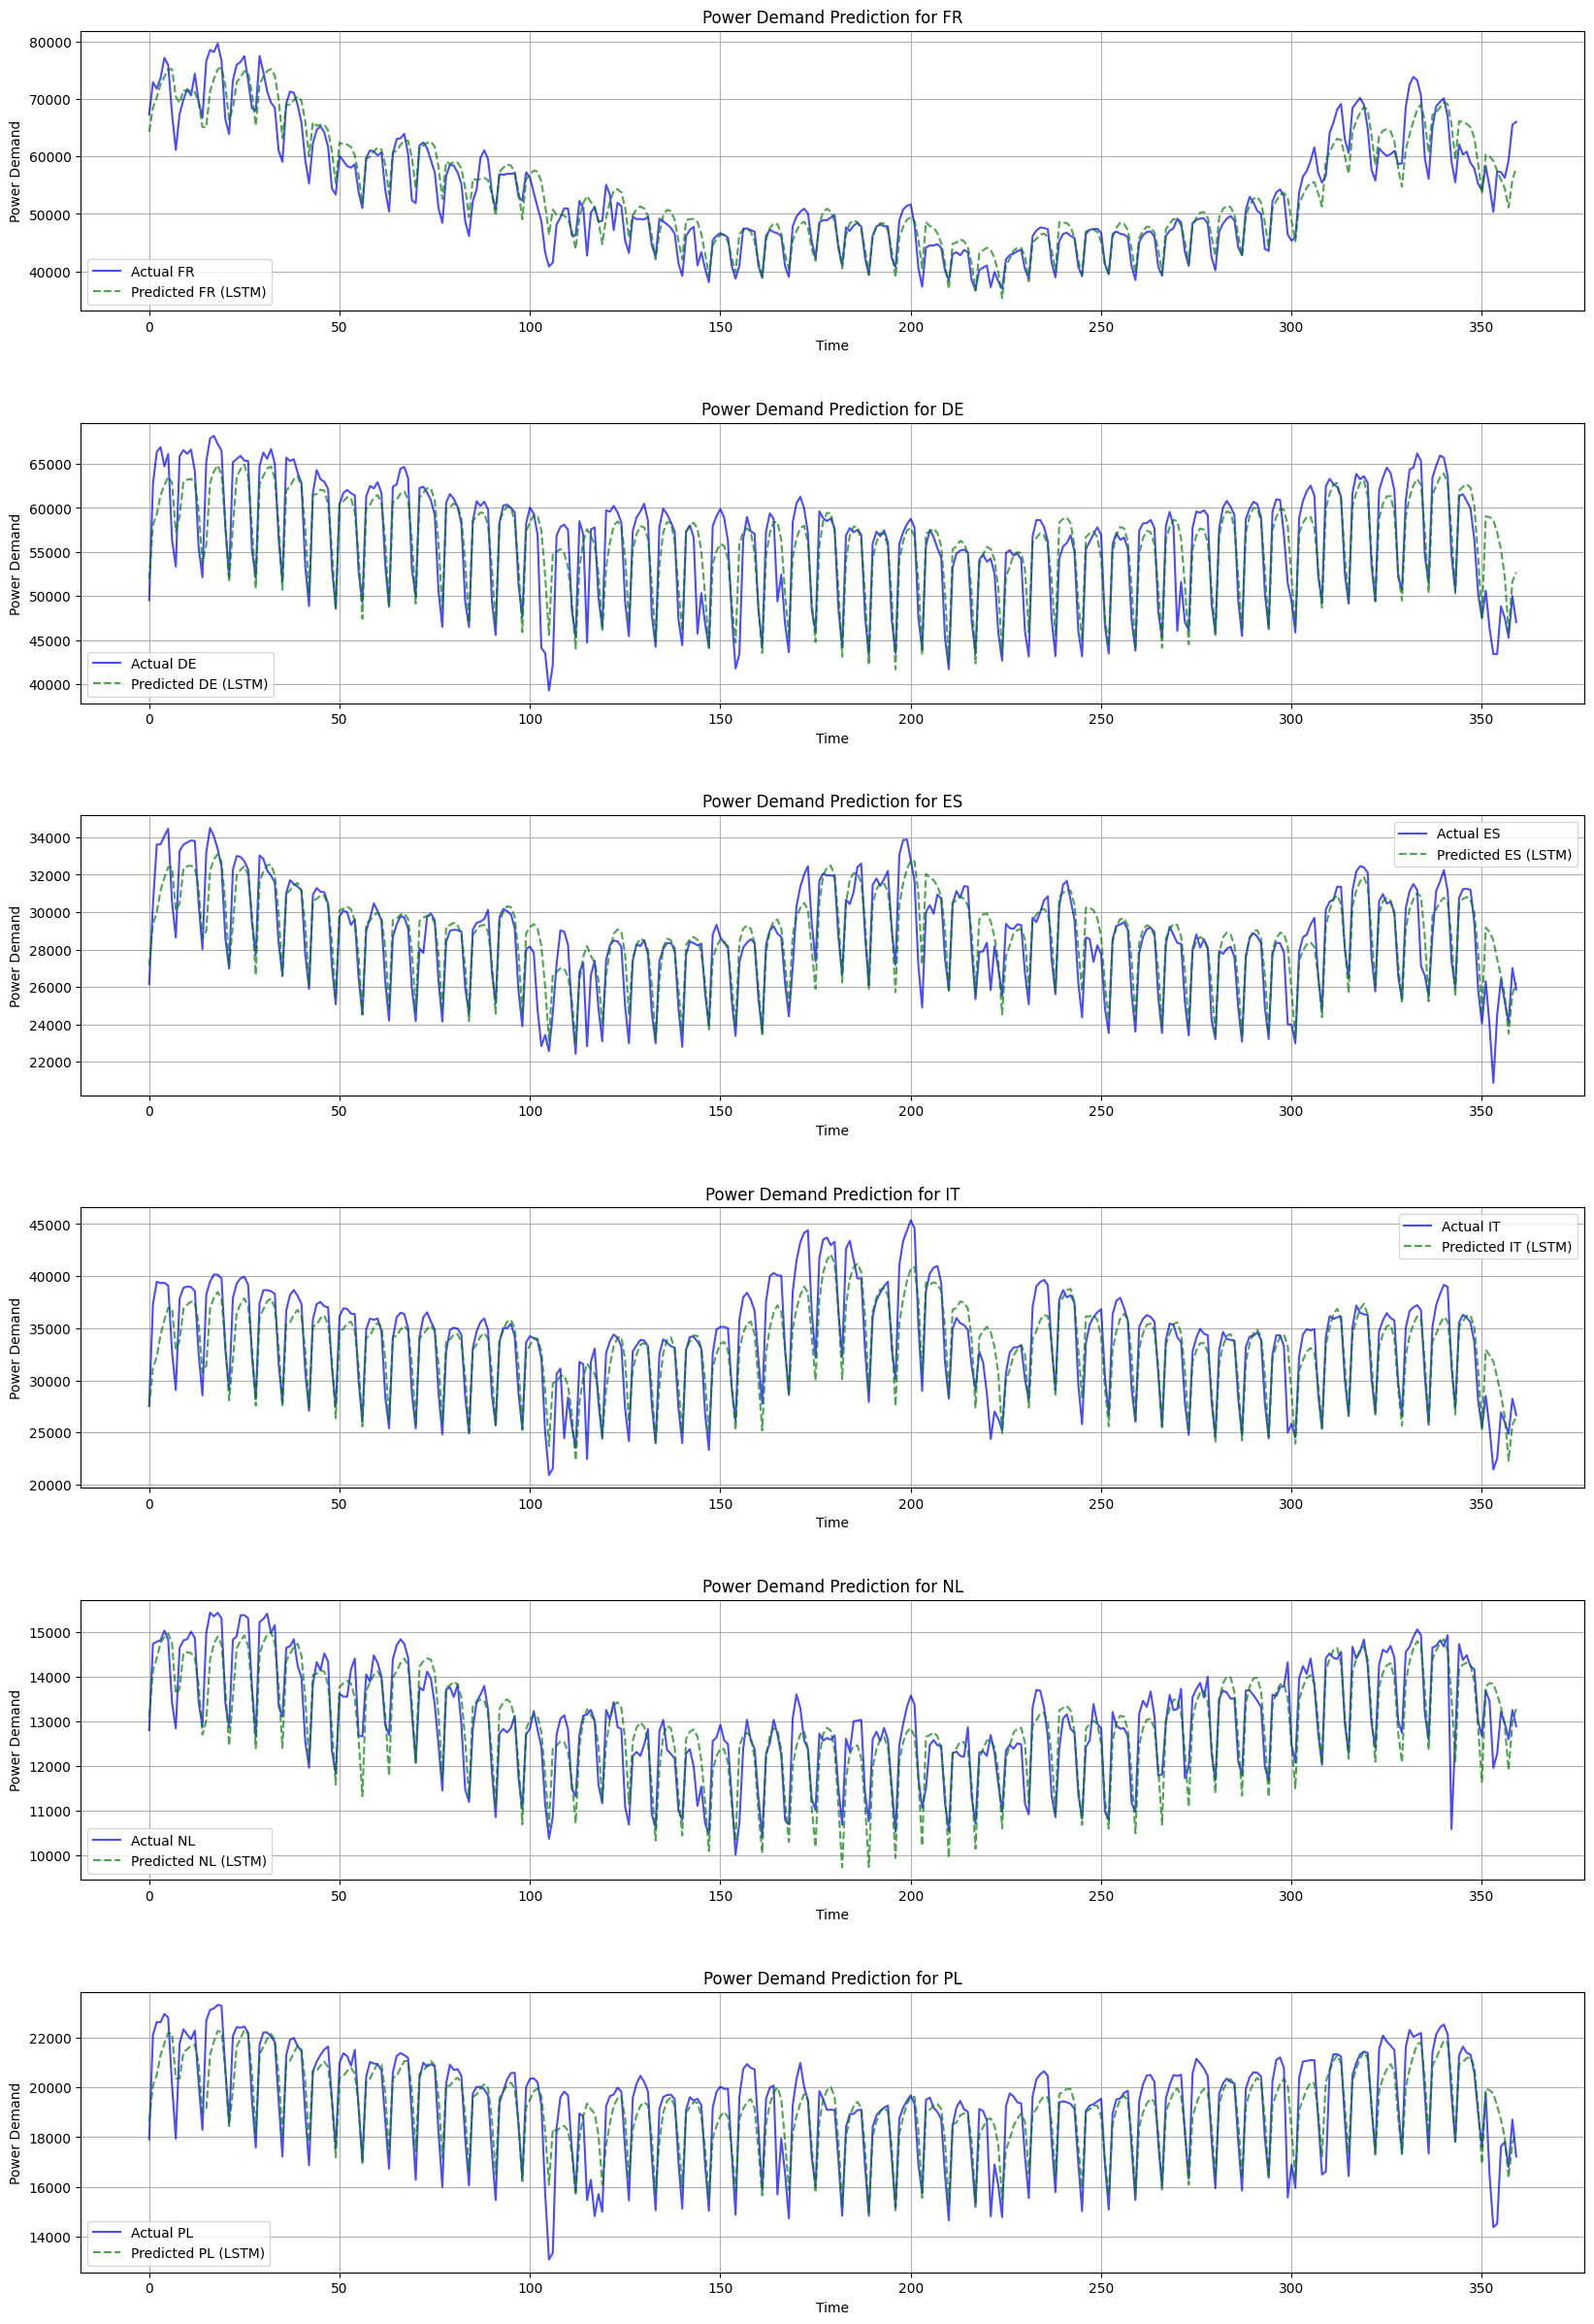

In [22]:
# Setting up the figure size for better visualization
plt.figure(figsize=(20, 30))

# Create subplots for each country
for i, country in enumerate(countries):
    plt.subplot(len(countries), 1, i + 1) #subplot

    # Plot actual vs predicted values for each model (Random Forest, XGBoost, and LSTM)
    plt.plot(y_test_original[:, i], label=f'Actual {country}', color='blue', alpha=0.7)
    plt.plot(lstm_preds_original[:, i], label=f'Predicted {country} (LSTM)', color='green', linestyle='--', alpha=0.7)
    # plt.plot(rf_predictions[:, i], label=f'Predicted {country} (RF)', color='red', linestyle='--', alpha=0.7)
    # plt.plot(xgb_predictions[:, i], label=f'Predicted {country} (XGBoost)', color='orange', linestyle='--', alpha=0.7)

    plt.title(f'Power Demand Prediction for {country}')
    plt.xlabel('Time')
    plt.ylabel('Power Demand')
    plt.legend()
    plt.grid(True)
    # plt.show()
plt.subplots_adjust(hspace=0.4)
# plt.tight_layout()
plt.show()

## Hybrid Model - ARIMA for linear patterns and Random Forest

In [40]:
lags = 7
# Fitting VARMAX model to capture linear patterns for all countries
arima_order = (1, 0)
arima_model = VARMAX(daily_data[target_columns], order=arima_order)
arima_results = arima_model.fit(disp=False)

# prediction
arima_fitted = arima_results.fittedvalues
arima_residuals = pd.DataFrame(arima_results.resid, columns=target_columns, index=daily_data.index[:len(arima_results.resid)])

final_forecasts = {}
evaluation_metrics = {}

# Looping through each country to build hybrid models
for country in countries:
    # print(f"Processing hybrid model for {country}...")

    # Selecting residuals for the current country
    residuals = arima_residuals[f'{country}_load_actual_entsoe_transparency']

    rf_data = pd.DataFrame({'residual': residuals})

    # Creating lagged features
    for lag in range(1, lags + 1):
        rf_data[f'lag_{lag}'] = rf_data['residual'].shift(lag)

    rf_data.dropna(inplace=True)

    train_size = int(len(rf_data) * 0.8)
    train_rf = rf_data.iloc[:train_size]
    test_rf = rf_data.iloc[train_size:]

    # Training Random Forest model for residuals
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(train_rf.iloc[:, 1:], train_rf['residual'])

    # Predicting residuals on test set
    rf_residual_preds = rf_model.predict(test_rf.iloc[:, 1:])

    # Combining ARIMA and RF predictions
    arima_forecast = arima_results.forecast(steps=len(test_rf))[f'{country}_load_actual_entsoe_transparency']
    arima_forecast = arima_forecast[:len(rf_residual_preds)]  # Match lengths

    # Final forecast = ARIMA forecast + predicted residuals
    final_forecast = arima_forecast + rf_residual_preds
    final_forecasts[country] = final_forecast

    # Evaluation
    test_actual = daily_data[f'{country}_load_actual_entsoe_transparency'].iloc[train_size + lags:]
    test_actual = test_actual[:len(final_forecast)]  # Match lengths

    rmse = root_mean_squared_error(test_actual, final_forecast)
    mae = mean_absolute_error(test_actual, final_forecast)
    mape = mean_absolute_percentage_error(test_actual, final_forecast)

    evaluation_metrics[country] = {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}


In [41]:
print("\nError Metrics for ARIMA + RF:")
for country, metrics in evaluation_metrics.items():
    print(f"{country} - RMSE: {metrics['RMSE']:.2f}, MAE: {metrics['MAE']:.2f}, MAPE: {metrics['MAPE']:.2%}")


Error Metrics for ARIMA + RF:
FR - RMSE: 8913.06, MAE: 7765.83, MAPE: 16.00%
DE - RMSE: 4409.06, MAE: 3434.43, MAPE: 6.49%
ES - RMSE: 2060.34, MAE: 1634.12, MAPE: 5.92%
IT - RMSE: 3597.59, MAE: 2755.97, MAPE: 8.56%
NL - RMSE: 849.71, MAE: 689.08, MAPE: 5.33%
PL - RMSE: 1381.47, MAE: 1069.27, MAPE: 5.81%


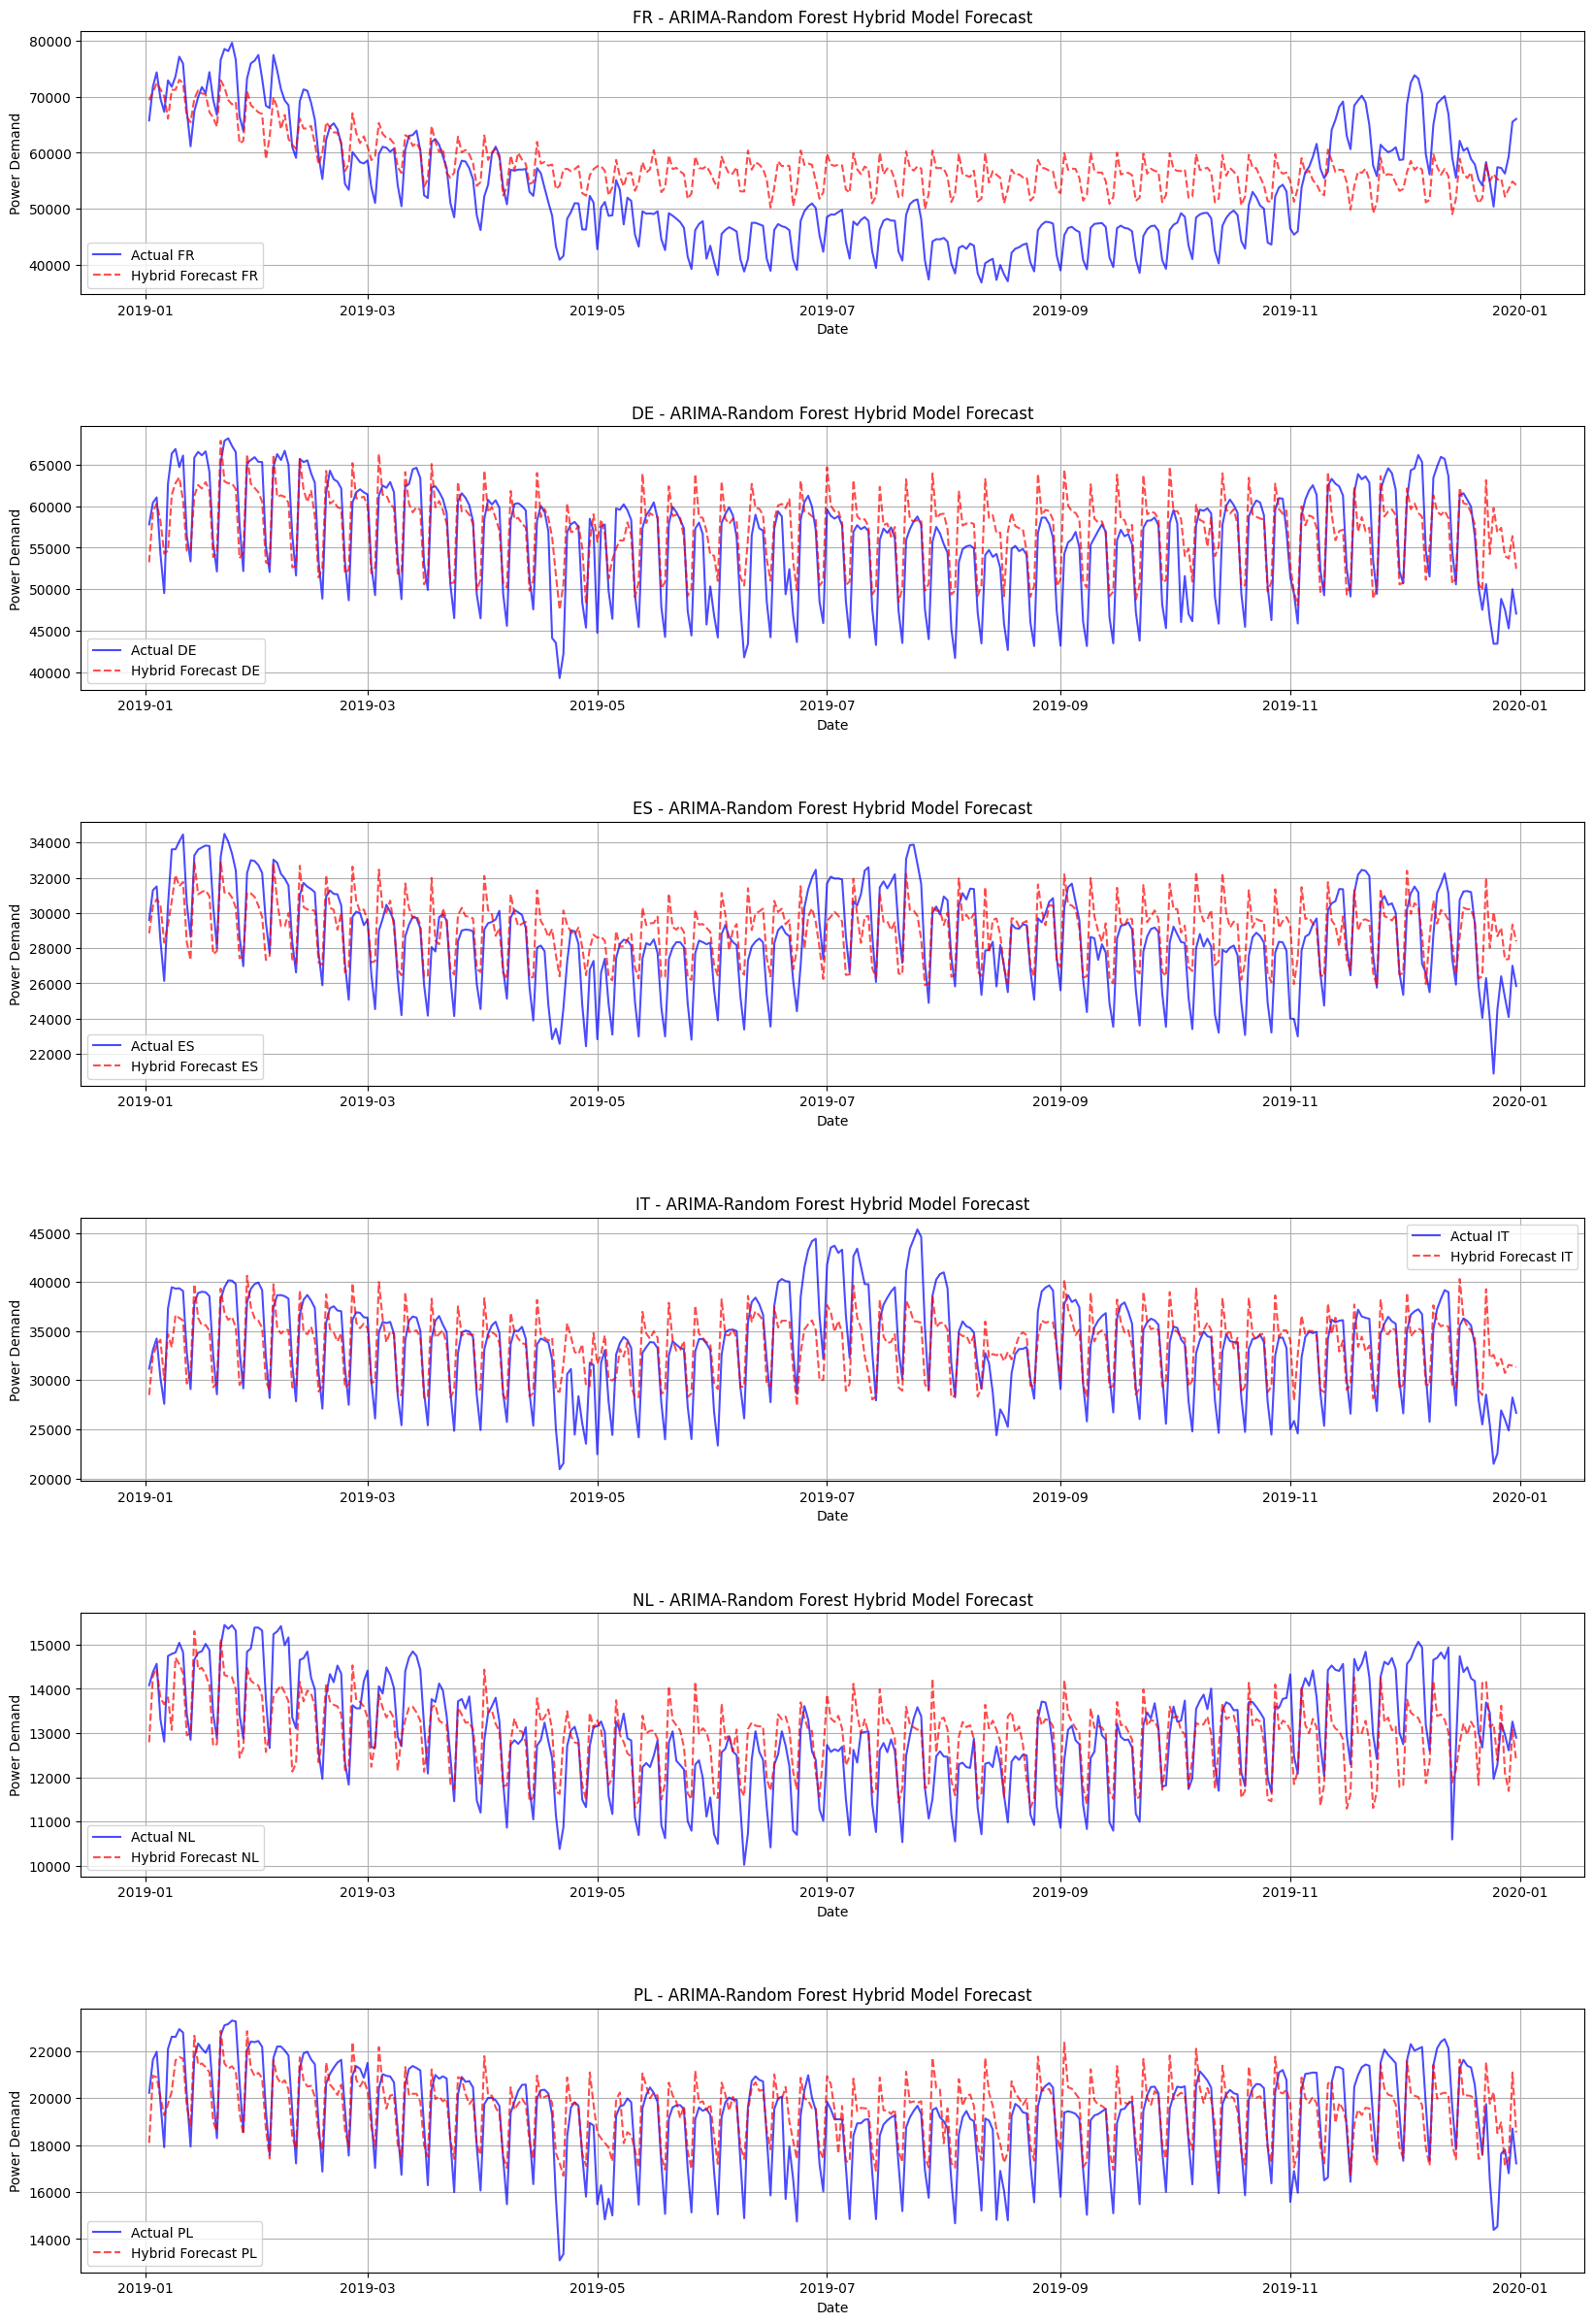

In [39]:
plt.figure(figsize=(20, 30))

# Plot results for each country
for i, country in enumerate(countries):
    test_actual = daily_data[f'{country}_load_actual_entsoe_transparency'].iloc[train_size + lags:]
    test_actual = test_actual[:len(final_forecasts[country])]  # Match lengths

    plt.subplot(len(countries), 1, i + 1)
    plt.plot(test_actual.index, test_actual, label=f'Actual {country}', color='blue', alpha=0.7)
    plt.plot(test_actual.index, final_forecasts[country], label=f'Hybrid Forecast {country}', color='red', linestyle='--', alpha=0.7)
    plt.title(f'{country} - ARIMA-Random Forest Hybrid Model Forecast')
    plt.xlabel('Date')
    plt.ylabel('Power Demand')
    plt.legend()
    plt.grid(True)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)
plt.show()

### Conclusion for Model Performances


---

#### **1. ARIMA Model Performance**:
- **Strengths**:
  - The ARIMA model captures linear trends well, especially for countries like **ES** (Spain) and **NL** (Netherlands), where the RMSE is relatively low.
  - Its performance is decent in countries with stable, predictable demand patterns.
  
- **Weaknesses**:
  - ARIMA struggles with higher variability, as seen in **IT** (Italy) and **DE** (Germany), where the RMSE values are higher.
  - The model is less effective in countries with more dynamic or volatile power demand.
  
**Key Observations**:
  - **FR (France)** and **IT (Italy)** see the highest RMSE values, indicating that ARIMA does not perform as well in countries with more fluctuating demand.
  - **MAPE** is generally reasonable, especially for **ES**, **NL**, and **PL**, but **DE** and **IT** see higher percentages.

---

#### **2. Random Forest (RF) Model Performance**:
- **Strengths**:
  - Random Forest significantly reduces RMSE values compared to ARIMA, especially in countries like **FR** (France), **ES** (Spain), and **PL** (Poland).
  - It performs exceptionally well for **ES**, **NL**, and **PL**, with very low MAE and MAPE, demonstrating its ability to handle non-linear relationships.
  
- **Weaknesses**:
  - Although RF generally improves over ARIMA, it still struggles with **DE** and **IT**, where the RMSE remains moderately high.
  - Random Forest may not capture long-term trends and seasonality effectively without further tuning.

**Key Observations**:
  - **ES** (Spain) and **PL** (Poland) benefit the most from RF, showing the lowest error metrics.
  - **DE** and **IT** still show higher RMSE values, suggesting that Random Forest is less effective in countries with more complex patterns.

---

#### **3. XGBoost Model Performance**:
- **Strengths**:
  - XGBoost, like Random Forest, improves on ARIMA, particularly in countries with stable or linear patterns like **ES**, **NL**, and **PL**.
  - It performs similarly to RF but has slightly higher RMSE for **DE** and **IT**, indicating that XGBoost struggles with more complex, volatile data.
  
- **Weaknesses**:
  - Similar to RF, XGBoost performs moderately well in most countries but doesn’t improve drastically over RF in terms of RMSE.
  
**Key Observations**:
  - **ES** and **PL** see the best performance in terms of RMSE and MAPE, while **DE** and **IT** experience higher errors, showing that XGBoost, while powerful, struggles with high variability in some countries.

---

#### **4. LSTM Model Performance**:
- **Strengths**:
  - LSTM demonstrates competitive performance across all countries, with error metrics similar to those of XGBoost and Random Forest.
  - It performs well in **ES** and **PL**, exhibiting relatively low RMSE and MAPE, which suggests that LSTM is effective in capturing temporal dependencies.
  
- **Weaknesses**:
  - Despite LSTM’s strength in time series forecasting, it doesn’t outperform RF or XGBoost in terms of RMSE across the board.
  - LSTM may not handle certain outliers or very volatile periods well, as seen in countries like **DE** and **IT**.

**Key Observations**:
  - Similar to RF and XGBoost, LSTM performs best in stable countries like **ES** and **PL**, but struggles with volatile periods in countries like **DE** and **IT**.

---

#### **5. ARIMA + RF Hybrid Model Performance**:
- **Strengths**:
  - The **Hybrid Model** (ARIMA + RF) appears to capture both the linear patterns (via ARIMA) and non-linear residuals (via RF), leading to a significant improvement in performance.
  - This model performs extremely well in terms of RMSE, MAE, and MAPE for **ES**, **NL**, and **PL**, showing much lower error rates compared to standalone ARIMA, RF, and XGBoost models.
  - The hybrid model compensates for ARIMA’s linearity by using RF to adjust the residuals, which is particularly effective in countries with seasonal or erratic demand patterns.

- **Weaknesses**:
  - The **Hybrid Model** does not outperform in countries like **DE** and **IT**, where **ARIMA** struggles, and **RF** alone cannot capture all complexities. Still, it is generally better than ARIMA alone.
  
**Key Observations**:
  - **FR** (France) shows high RMSE with the Hybrid Model, suggesting that the model might not be well-suited for countries with a mix of high volatility and stable demand.
  - **ES** and **PL** show the best results in terms of **RMSE** and **MAPE**, reinforcing the hybrid model’s effectiveness in such regions.

---

### **Summary of Model Performance**:
- **Best Performers**: The **Hybrid Model (ARIMA + RF)** delivers the best results in terms of RMSE, MAE, and MAPE for **ES** (Spain), **NL** (Netherlands), and **PL** (Poland), which have relatively more stable and predictable power demand patterns.
- **Challenges for ARIMA**: **ARIMA** struggles with countries that have more volatile power demand patterns, such as **IT** (Italy) and **DE** (Germany), where both **RF** and **XGBoost** outperform it.
- **Competitive Models**: Both **Random Forest** and **XGBoost** provide significant improvements over **ARIMA**, with **LSTM** also showing competitive performance, especially in capturing time-dependent patterns.
- **Hybrid Approach's Value**: The **Hybrid Model** performs well when combining ARIMA's strengths for linear trends and RF’s flexibility to model residuals, but it’s not universally superior to other models in all countries.

### **Final Conclusion**:
- For **countries with stable, predictable demand patterns** like **ES**, **NL**, and **PL**, the **Hybrid Model** offers the best overall performance.
- For countries like **DE** and **IT**, a combination of **Random Forest** or **XGBoost** with some additional feature engineering might be more effective than relying on ARIMA.